<a href="https://colab.research.google.com/github/jtorresle/AlgorithmsUN2024II/blob/main/Lab2.2/jtorresle_Lab2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Broadcasting Review

- Numpy operations can work on arrays of different dimensions as long as the arrays' shapes are still "compatible".
- Broadcasting works by "tiling" the smaller array along the missing dimension.
- The result of a broadcasted operation is always at least as large in each dimension as the largest array in that dimension.

# Numpy Review

- Numerical algorithms are slow in pure Python because the overhead dynamic dispatch dominates our runtime.

- Numpy solves this problem by:
  1. Imposing additional restrictions on the contents of arrays.
  2. Moving the inner loops of our algorithms into compiled C code.

- Using Numpy effectively often requires reworking an algorithms to use vectorized operations instead of for-loops, but the resulting operations are usually simpler, clearer, and faster than the pure Python equivalent.

<center><img src="https://raw.githubusercontent.com/ssanderson/pydata-toolbox/master/notebooks/images/unicorn.jpg" alt="Drawing" style="width: 75%;"/></center>

Numpy is great for many things, but...

- Sometimes our data is equipped with a natural set of **labels**:
  - Dates/Times
  - Stock Tickers
  - Field Names (e.g. Open/High/Low/Close)

- Sometimes we have **more than one type of data** that we want to keep grouped together.
  - Tables with a mix of real-valued and categorical data.

- Sometimes we have **missing** data, which we need to ignore, fill, or otherwise work around.

<center><img src="https://raw.githubusercontent.com/ssanderson/pydata-toolbox/master/notebooks/images/panda-wrangling.gif" alt="Drawing" style="width: 75%;"/></center>

<center><img src="https://raw.githubusercontent.com/ssanderson/pydata-toolbox/master/notebooks/images/pandas_logo.png" alt="Drawing" style="width: 75%;"/></center>


Pandas extends Numpy with more complex data structures:

- `Series`: 1-dimensional, homogenously-typed, labelled array.
- `DataFrame`: 2-dimensional, semi-homogenous, labelled table.

Pandas also provides many utilities for:
- Input/Output
- Data Cleaning
- Rolling Algorithms
- Plotting

# Selection in Pandas

In [ ]:
s = pd.Series(index=['a', 'b', 'c', 'd', 'e'], data=[1, 2, 3, 4, 5])
s

a    1
b    2
c    3
d    4
e    5
dtype: int64

In [ ]:
# There are two pieces to a Series: the index and the values.
print("The index is:", s.index)
print("The values are:", s.values)

The index is: Index(['a', 'b', 'c', 'd', 'e'], dtype='object')
The values are: [1 2 3 4 5]


In [ ]:
# We can look up values out of a Series by position...
s.iloc[0]

1

In [ ]:
# ... or by label.
s.loc['a']

1

In [ ]:
# Slicing works as expected...
s.iloc[:2]

a    1
b    2
dtype: int64

In [ ]:
# ...but it works with labels too!
s.loc[:'c']

a    1
b    2
c    3
dtype: int64

In [ ]:
# Fancy indexing works the same as in numpy.
s.iloc[[0, -1]]

a    1
e    5
dtype: int64

In [ ]:
# As does boolean masking.
s.loc[s > 2]

c    3
d    4
e    5
dtype: int64

In [ ]:
# Element-wise operations are aligned by index.
other_s = pd.Series({'a': 10.0, 'c': 20.0, 'd': 30.0, 'z': 40.0})
other_s

a    10.0
c    20.0
d    30.0
z    40.0
dtype: float64

In [ ]:
s + other_s

a    11.0
b     NaN
c    23.0
d    34.0
e     NaN
z     NaN
dtype: float64

In [ ]:
# We can fill in missing values with fillna().
(s + other_s).fillna(0.0)

a    11.0
b     0.0
c    23.0
d    34.0
e     0.0
z     0.0
dtype: float64

In [ ]:
# Most real datasets are read in from an external file format.
aapl = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
aapl.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,27.613066,30.572857,30.642857,30.340000,30.490000,123432400.0
2010-01-05,27.660807,30.625713,30.798571,30.464285,30.657143,150476200.0
2010-01-06,27.220825,30.138571,30.747143,30.107143,30.625713,138040000.0
2010-01-07,27.170504,30.082857,30.285715,29.864286,30.250000,119282800.0
2010-01-08,27.351143,30.282858,30.285715,29.865715,30.042856,111902700.0


In [ ]:
# Slicing generalizes to two dimensions as you'd expect:
aapl.iloc[:2, :2]

,Adj Close,Close
Date,,
2010-01-04,27.613066,30.572857
2010-01-05,27.660807,30.625713


In [ ]:
aapl.loc[pd.Timestamp('2010-02-01'):pd.Timestamp('2010-02-04'), ['Close', 'Volume']]

,Close,Volume
Date,,
2010-02-01,27.818571,187469100.0
2010-02-02,27.980000,174585600.0
2010-02-03,28.461428,153832000.0
2010-02-04,27.435715,189413000.0


# Rolling Operations

<center><img src="https://raw.githubusercontent.com/ssanderson/pydata-toolbox/master/notebooks/images/rolling.gif" alt="Drawing" style="width: 75%;"/></center>

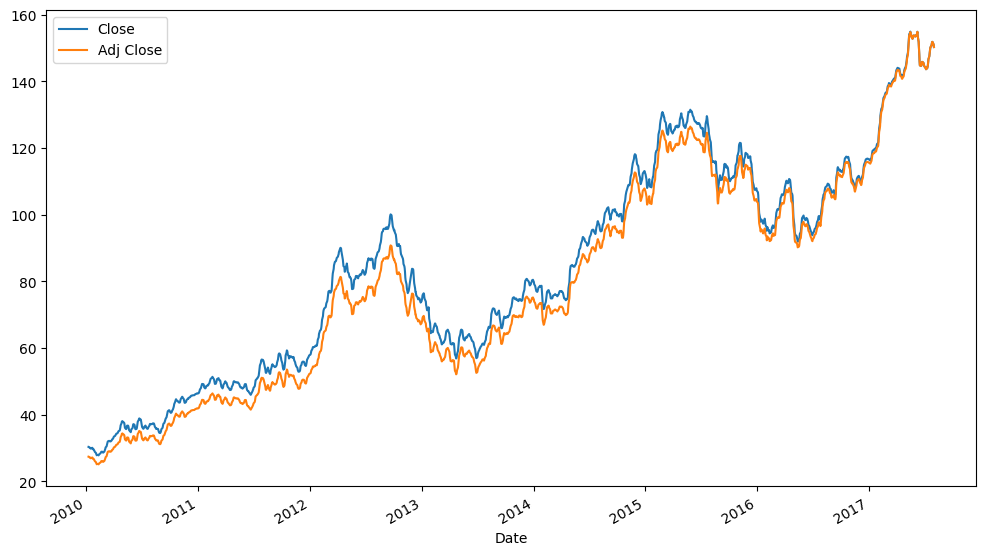

In [ ]:
aapl.rolling(5)[['Close', 'Adj Close']].mean().plot();

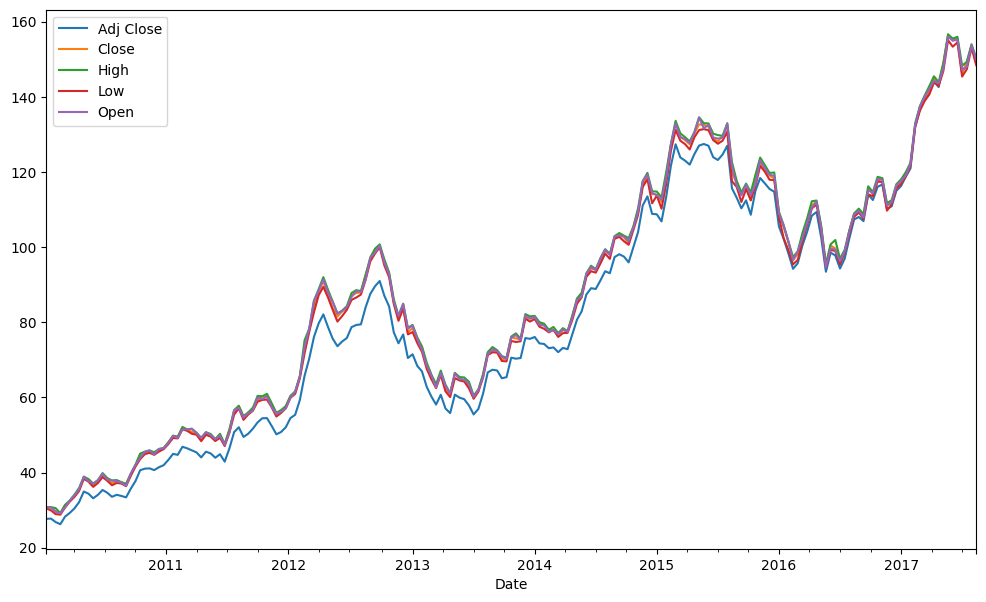

In [ ]:
# Drop `Volume`, since it's way bigger than everything else.
aapl.drop('Volume', axis=1).resample('2W').max().plot();

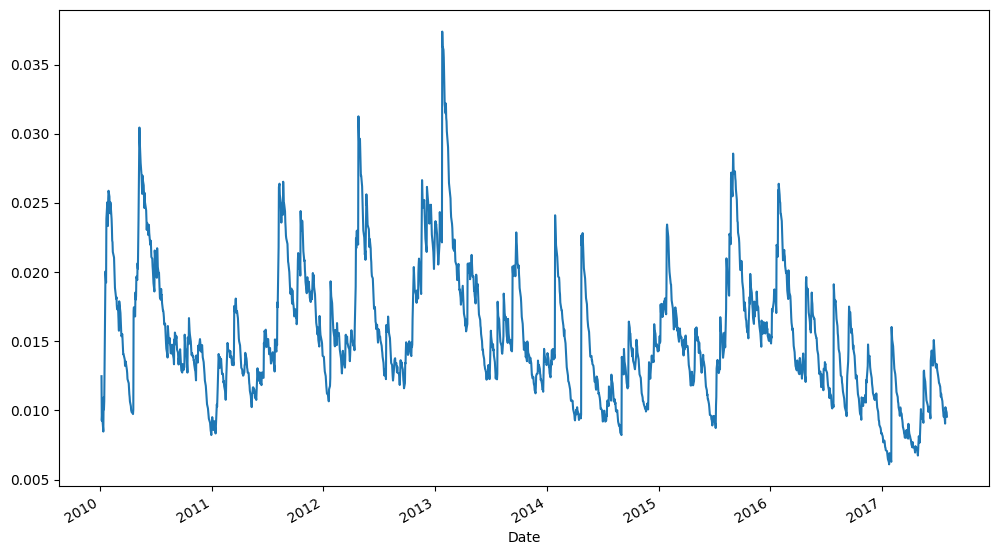

In [ ]:
# 30-day rolling exponentially-weighted stddev of returns.
aapl['Close'].pct_change().ewm(span=30).std().plot();

# "Real World" Data

In [ ]:
from io import BytesIO
import os
from urllib.parse import urlencode

import requests
import numpy as np
import pandas as pd


def read_avocadata(start_date, end_date, cache_loc='avocadata.html'):
    """Download avocado data to a dataframe.
    Parameters
    ----------
    """
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    base_url = 'https://www.marketnews.usda.gov/mnp/fv-report-retail'
    query_params = {
        'class': ['FRUITS'],
        'commodity': ['AVOCADOS'],
        'compareLy': ['No'],
        'endDate': [end_date.strftime("%m/%d/%Y")],
        'format': ['excel'],
        'organic': ['ALL'],
        'portal': ['fv'],
        'region': ['ALL'],
        'repDate': [start_date.strftime("%m/%d/%Y")],
        'type': ['retail'],
    }

    url = base_url + '?' + urlencode(query_params, doseq=1)

    if not os.path.exists(cache_loc):
        resp = requests.get(url, stream=True)
        resp.raise_for_status()

        with open(cache_loc, 'wb') as f:
            for block in resp.iter_content(chunk_size=4096):
                f.write(block)
        f.close()

    with open(cache_loc, 'rb') as f:
        frame = pd.read_html(f, header=0)[0]

    # Cleanup
    frame = frame[frame['Unit'] == 'each']
    frame['Organic'] = (frame['Organic'] == 'Y')
    frame['Variety'].replace(
        {'VARIOUS GREENSKIN VARIETIES': 'GREENSKIN'},
        inplace=True,
    )
    frame['Date'] = pd.to_datetime(frame['Date'].values, utc=True)

    frame['Region'] = frame['Region'].str.replace(' U.S.', '')
    frame['Region'] = frame['Region'].str.replace(' ', '_')

    # Drop useless columns.
    return frame.drop(
        ['Class', 'Commodity', 'Environment', 'Unit', '% Marked Local'],
        axis=1,
    )


In [ ]:
# from demos.avocados import read_avocadata

avocados = read_avocadata('2014', '2016')
avocados.head()

<ipython-input-2-74fdf899ad9d>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Region'] = frame['Region'].str.replace(' U.S.', '')


,Date,Region,Variety,Organic,Number of Stores,Weighted Avg Price,Low Price,High Price
0,2014-01-03 00:00:00+00:00,NATIONAL,HASS,False,9184,0.93,NaN,NaN
1,2014-01-03 00:00:00+00:00,NATIONAL,HASS,True,872,1.44,NaN,NaN
2,2014-01-03 00:00:00+00:00,NORTHEAST,HASS,False,1449,1.08,0.5,1.67
3,2014-01-03 00:00:00+00:00,NORTHEAST,HASS,True,66,1.54,1.5,2.00
4,2014-01-03 00:00:00+00:00,SOUTHEAST,HASS,False,2286,0.98,0.5,1.99


**My own example 34**

In [ ]:
import requests
import pandas as pd

results = requests.get("https://www.datos.gov.co/resource/3prj-n3fb.json")

To_json = results.json()

datos = pd.DataFrame(To_json)



datos.head()

,ano,mes,codigo_rnt,cod_mun,cod_dpto,estado_rnt,razon_social_establecimiento,departamento,municipio1,categoria1,sub_categoria1,habitaciones1,camas1,num_emp1
0,2023,3,17595,76364,76,ACTIVO,HOTEL JAMUNDI REAL,VALLE DEL CAUCA,JAMUNDI,ESTABLECIMIENTOS DE ALOJAMIENTO TURÍSTICO,HOTEL,39,45,3
1,2023,3,19559,76364,76,ACTIVO,HOSTAL PANORAMA,VALLE DEL CAUCA,JAMUNDI,ESTABLECIMIENTOS DE ALOJAMIENTO TURÍSTICO,HOSTAL,25,31,3
2,2023,2,19560,76364,76,ACTIVO,HOSTAL PARAISO JAMUNDI,VALLE DEL CAUCA,JAMUNDI,ESTABLECIMIENTOS DE ALOJAMIENTO TURÍSTICO,HOSTAL,25,31,3
3,2023,3,26177,76364,76,ACTIVO,HOSTAL PORTAL DEL SOL,VALLE DEL CAUCA,JAMUNDI,ESTABLECIMIENTOS DE ALOJAMIENTO TURÍSTICO,HOSTAL,32,35,3
4,2023,3,26662,76364,76,ACTIVO,GRUPO AVENTURA,VALLE DEL CAUCA,JAMUNDI,AGENCIAS DE VIAJES,AGENCIA DE VIAJES OPERADORAS,0,0,0


In [ ]:
# Unlike numpy arrays, pandas DataFrames can have a different dtype for each column.
avocados.dtypes

Date                  datetime64[ns, UTC]
Region                             object
Variety                            object
Organic                              bool
Number of Stores                    int64
Weighted Avg Price                float64
Low Price                         float64
High Price                        float64
dtype: object

**My own example 35**

In [ ]:
datos.dtypes

Orden                         object
Clase                         object
Marca                         object
Modelo                        object
Fecha Matricula Radicacion    object
Año                           object
Mes                           object
Día                           object
dtype: object

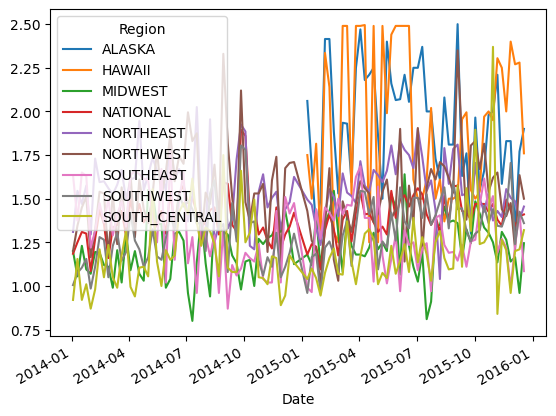

In [ ]:
# What's the regional average price of a HASS avocado every day?
hass = avocados[avocados.Variety == 'HASS']
hass.groupby(['Date', 'Region'])['Weighted Avg Price'].mean().unstack().ffill().plot();

**My ow example 36**

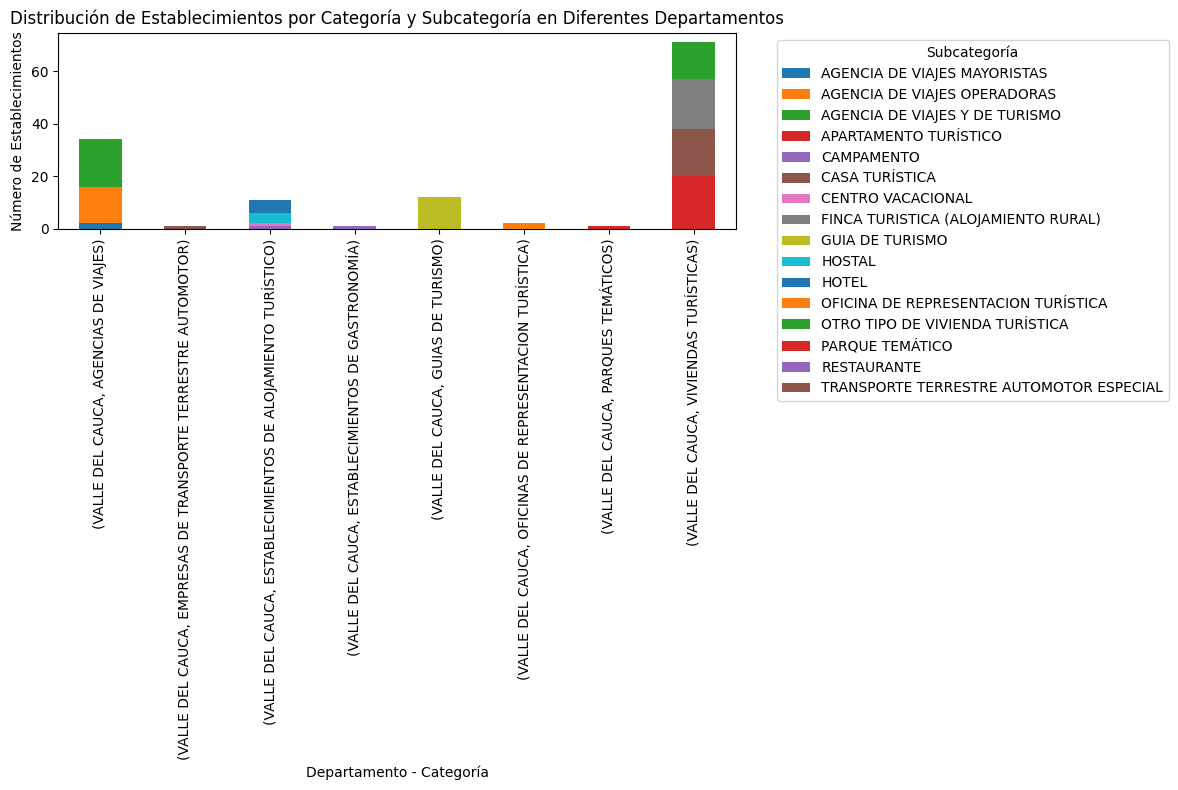

In [ ]:
# Agrupar por departamento, categoría y subcategoría y sumar el número de establecimientos
grouped = datos.groupby(['departamento', 'categoria1', 'sub_categoria1'])[['razon_social_establecimiento']].count().reset_index()

# Pivotear los datos para crear un gráfico de barras apiladas
pivot = grouped.pivot_table(index=['departamento', 'categoria1'], columns='sub_categoria1', values='razon_social_establecimiento', fill_value=0)

# Crear el gráfico de barras apiladas
ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribución de Establecimientos por Categoría y Subcategoría en Diferentes Departamentos')
plt.xlabel('Departamento - Categoría')
plt.ylabel('Número de Establecimientos')
plt.legend(title='Subcategoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
def _organic_spread(group):

    if len(group.columns) != 2:
        return pd.Series(index=group.index, data=0.0)

    is_organic = group.columns.get_level_values('Organic').values.astype(bool)
    organics = group.loc[:, is_organic].squeeze()
    non_organics = group.loc[:, ~is_organic].squeeze()
    diff = organics - non_organics
    return diff

def organic_spread_by_region(df):
    """What's the difference between the price of an organic
    and non-organic avocado within each region?
    """
    return (
        df
        .set_index(['Date', 'Region', 'Organic'])
         ['Weighted Avg Price']
        .unstack(level=['Region', 'Organic'])
        .ffill()
        .groupby(level='Region', axis=1)
        .apply(_organic_spread)
    )

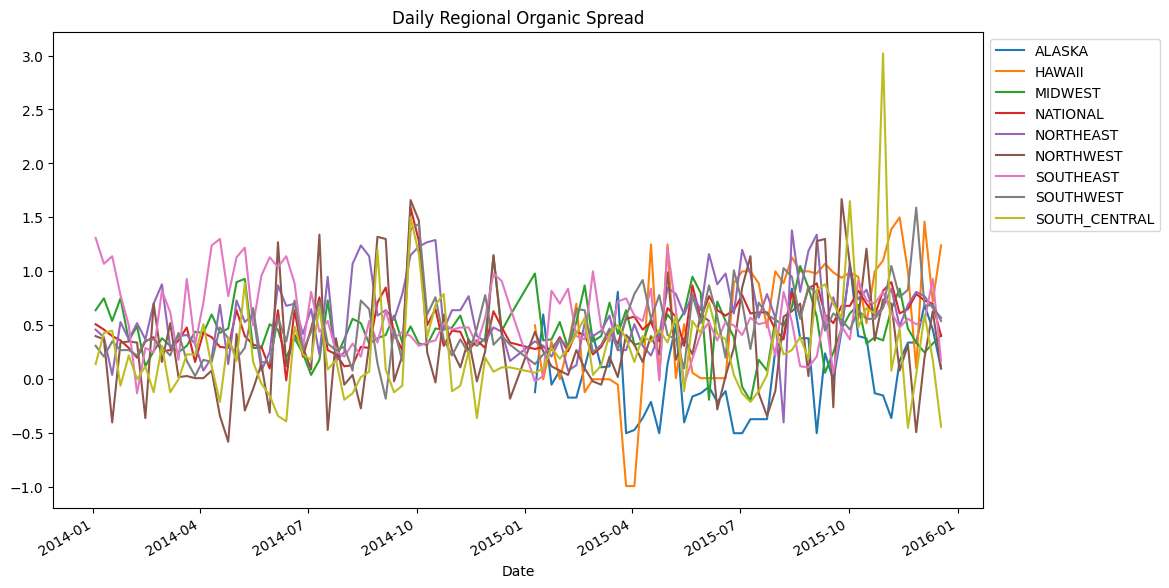

In [ ]:
organic_spread_by_region(hass).plot();
plt.gca().set_title("Daily Regional Organic Spread");
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
spread_correlation = organic_spread_by_region(hass).corr()
spread_correlation

Region,ALASKA,HAWAII,MIDWEST,NATIONAL,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,SOUTH_CENTRAL
Region,,,,,,,,,
ALASKA,1.000000,0.202723,0.175251,0.007844,0.051049,0.087575,0.129079,-0.070868,0.161624
HAWAII,0.202723,1.000000,-0.021116,0.373914,0.247171,0.341155,0.019388,0.159192,0.092632
MIDWEST,0.175251,-0.021116,1.000000,0.062595,-0.010213,-0.043783,0.047437,-0.059128,0.068902
NATIONAL,0.007844,0.373914,0.062595,1.000000,0.502035,0.579102,-0.040539,0.635006,0.486524
NORTHEAST,0.051049,0.247171,-0.010213,0.502035,1.000000,0.242039,-0.236225,0.360389,0.149881
NORTHWEST,0.087575,0.341155,-0.043783,0.579102,0.242039,1.000000,-0.032306,0.165992,0.349935
SOUTHEAST,0.129079,0.019388,0.047437,-0.040539,-0.236225,-0.032306,1.000000,-0.167631,-0.021176
SOUTHWEST,-0.070868,0.159192,-0.059128,0.635006,0.360389,0.165992,-0.167631,1.000000,0.254504
SOUTH_CENTRAL,0.161624,0.092632,0.068902,0.486524,0.149881,0.349935,-0.021176,0.254504,1.000000


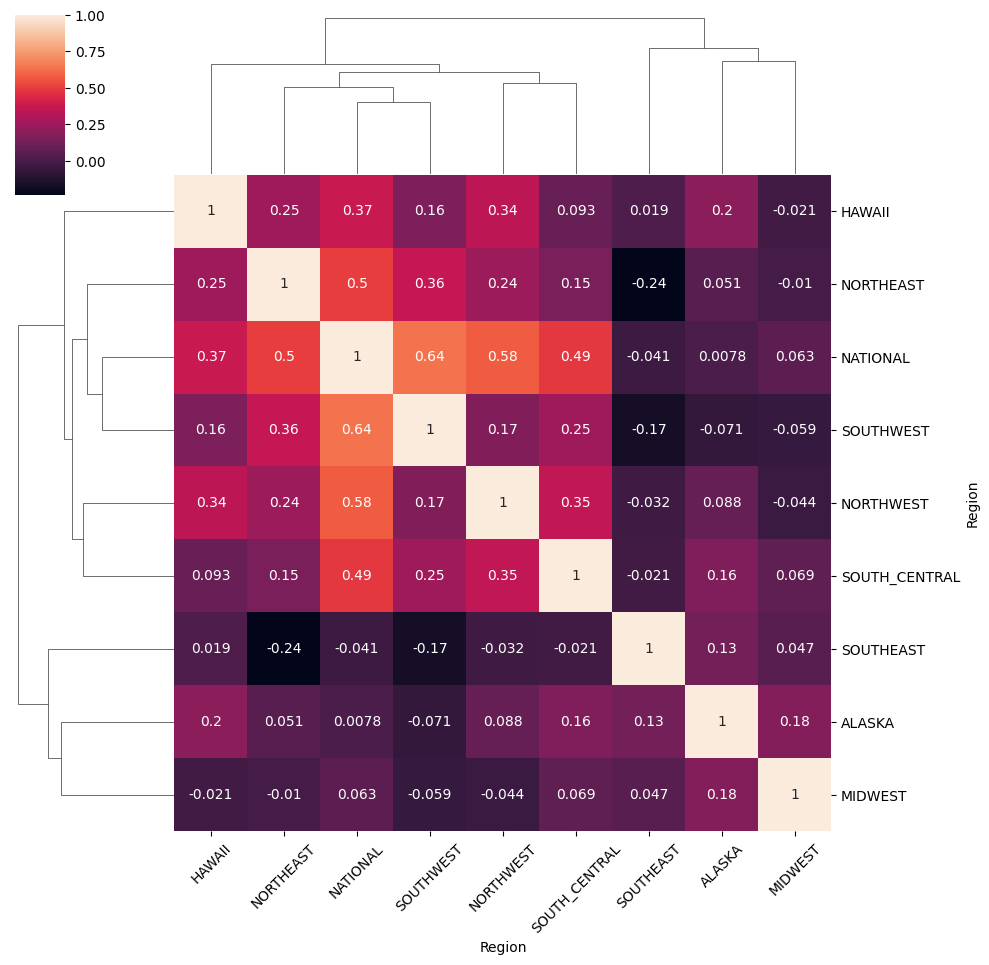

In [ ]:
import seaborn as sns
grid = sns.clustermap(spread_correlation, annot=True)
fig = grid.fig
axes = fig.axes
ax = axes[2]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

**My own example 37**

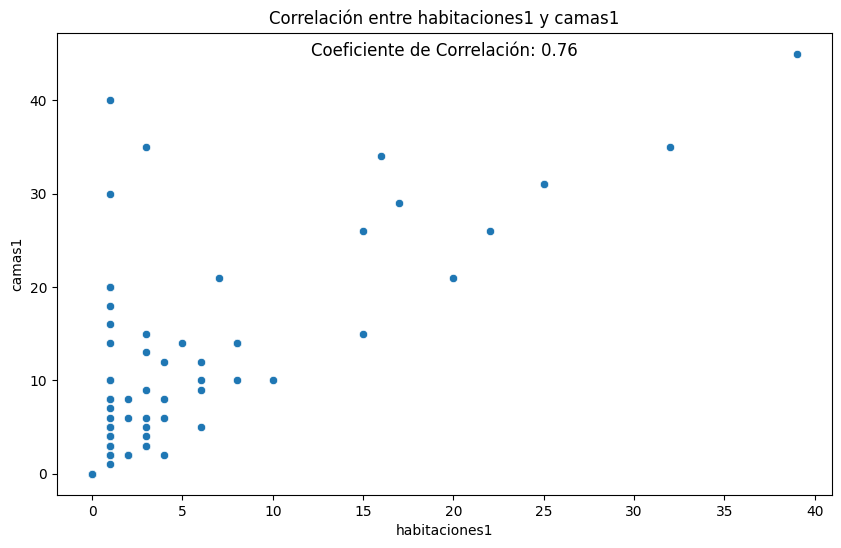

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar dos variables para analizar la correlación
variable1 = 'habitaciones1'
variable2 = 'camas1'

datos[variable1] = datos[variable1].apply(lambda x: int(x))
datos[variable2] = datos[variable2].apply(lambda x: int(x))

# Crear un gráfico de dispersión y calcular el coeficiente de correlación
plt.figure(figsize=(10, 6))
sns.scatterplot(data=datos, x=variable1, y=variable2)
plt.title(f'Correlación entre {variable1} y {variable2}')
plt.xlabel(variable1)
plt.ylabel(variable2)

# Calcular el coeficiente de correlación de Pearson
correlation_coefficient = datos[variable1].corr(datos[variable2])
plt.annotate(f'Coeficiente de Correlación: {correlation_coefficient:.2f}',
             xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=12)

plt.show()


# Pandas Review

- Pandas extends numpy with more complex datastructures and algorithms.
- If you understand numpy, you understand 90% of pandas.
- `groupby`, `set_index`, and `unstack` are powerful tools for working with categorical data.
- Avocado prices are surprisingly interesting :)

# Thanks!